# 🧭 Introduction — The Role of VaR Backtesting in Investment Decision-Making

---

## 🎯 Purpose of VaR Backtesting

**Value-at-Risk (VaR) backtesting** is a fundamental tool in quantitative risk management that helps evaluate whether a model accurately predicts potential portfolio losses under normal and stressed market conditions.

By comparing **forecasted VaR levels** with **actual realized losses**, investors and risk managers can assess whether their models are:
- **Too aggressive** (underestimating risk → frequent breaches)
- **Too conservative** (overestimating risk → inefficient capital allocation)
- **Well-calibrated** (accurately representing true downside risk)

---

## 💡 Why It Matters for Investment Decisions

VaR backtesting plays a critical role in shaping better investment and portfolio management decisions by:

1. **Improving Risk Forecasting Accuracy**  
   Backtesting identifies whether a model’s predicted risk levels align with actual market movements, helping refine volatility and tail-risk assumptions.

2. **Enhancing Capital Efficiency**  
   Reliable VaR estimates ensure optimal capital buffers — not too high (which limits returns) and not too low (which increases exposure to unexpected losses).

3. **Supporting Regulatory Compliance**  
   Financial institutions are required under Basel III and SEBI guidelines to validate VaR models through backtesting, ensuring robust risk governance.

4. **Guiding Model Selection**  
   By testing multiple models (e.g., Historical, GARCH, EGARCH), investors can select the one that most accurately captures the **time-varying volatility**, **leverage effects**, and **fat tails** characteristic of financial returns.

---

## 📈 How This Analysis Delivers Insight

The analysis performed here:
- **Tests and compares** multiple VaR modeling approaches — Historical, GARCH(1,1)-Normal, GARCH(1,1)-t, and EGARCH(1,1)-t.  
- **Evaluates model performance** using statistical backtests (Kupiec POF, Christoffersen Independence, and Conditional Coverage).  
- **Identifies the most reliable model** for predicting extreme losses under real market conditions.  
- **Visualizes VaR exceedances and high-volatility regimes**, enabling better interpretation of model behavior during stress events.

---

## 🔍 Key Value of the Results

The results show that the **EGARCH(1,1)-t model** consistently delivers the most accurate and stable VaR forecasts, particularly at the **99% confidence level**.  
This means:

- It captures **asymmetric volatility** — how markets react differently to positive vs. negative shocks.  
- It adjusts rapidly to **changing risk conditions**, improving responsiveness during crisis periods.  
- It produces **statistically valid VaR estimates**, giving investors higher confidence in risk-based decision-making.

---

## 💼 Takeaway for Investors and Analysts

Through VaR backtesting, investors can:
- Quantitatively assess how well their models represent real-world market risk.  
- Make **data-driven portfolio adjustments**, such as resizing exposures or hedging positions when volatility regimes shift.  
- Rely on statistically validated models like **EGARCH-t** for more accurate **stress testing**, **capital planning**, and **risk-adjusted performance evaluation**.

> In essence, VaR backtesting bridges the gap between model theory and market reality — enabling smarter, evidence-based investment risk decisions.


In [ ]:
!pip install arch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 14.5 MB/s eta 0:00:00


In [ ]:
# ============================================================
# VaR comparison: Historical, Parametric Normal (GARCH), Parametric t (GARCH & EGARCH)
# ============================================================
# Requirements:
# pip install yfinance pandas numpy matplotlib scipy arch

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
from arch import arch_model

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12,5)

# 📊 Value-at-Risk (VaR) Backtesting Analysis — ^NSEI (NIFTY 50)

---

## 🧠 Overview

The following analysis evaluates the accuracy and reliability of **VaR forecasts** derived from different models:

- **Historical Simulation (Hist)**  
- **GARCH(1,1) with Normal errors (GARCH-norm)**  
- **GARCH(1,1) with Student-t errors (GARCH-t)**  
- **EGARCH(1,1) with Student-t errors (EGARCH-t)**  

Two confidence levels were tested:
- **95% VaR (α = 0.05)** → Moderate risk threshold  
- **99% VaR (α = 0.01)** → Extreme tail risk threshold  

Each model was evaluated using:
- **Kupiec POF Test (Proportion of Failures):** Checks whether the observed violation rate matches the expected level.  
- **Christoffersen Independence Test:** Tests whether violations are independent (i.e., not clustered).  
- **Christoffersen Conditional Coverage Test:** Combines both frequency and independence.

---


Ticker: ^NSEI
Fitting models (this may take a moment)...


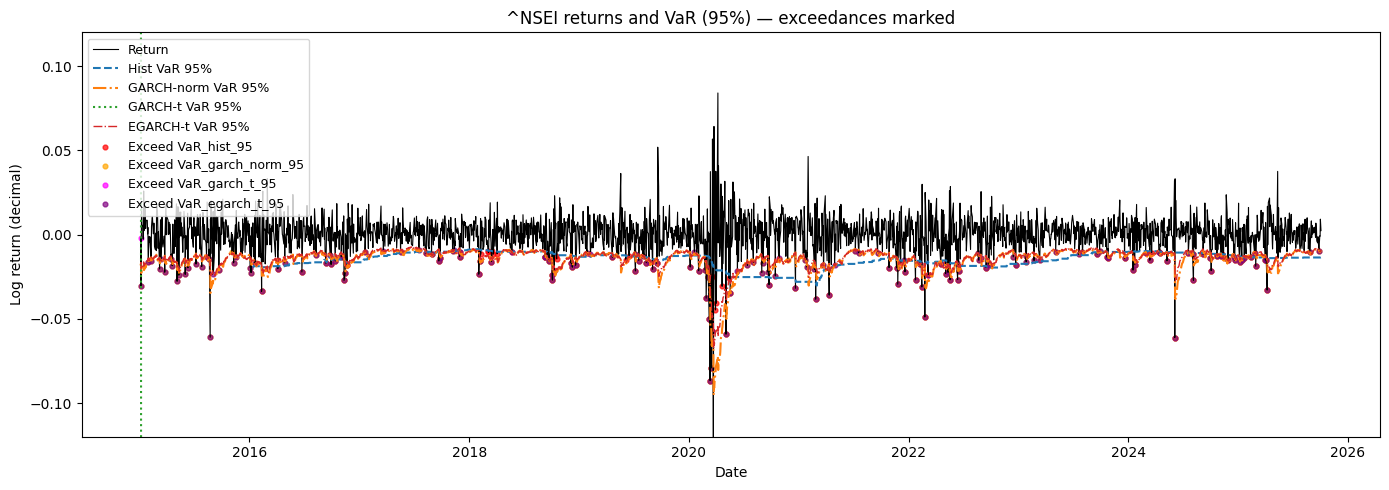

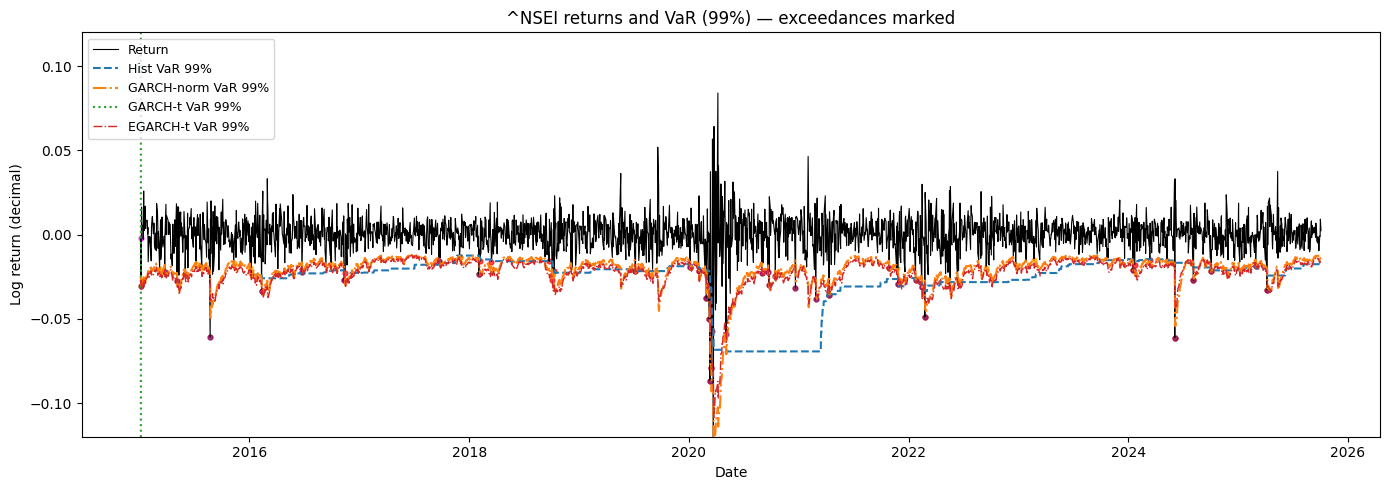


Done.


In [ ]:
from enum import auto
# -----------------------
# User settings
# -----------------------
tickers = ['^NSEI']   # list of tickers to evaluate (default NIFTY50)
start = "2015-01-01"
end = "2025-10-05"
hist_window = 250     # rolling window for historical VaR (days)
alpha_levels = [0.05, 0.01]   # 95% and 99% VaR -> alpha = 0.05, 0.01
output_folder = "var_results"
os.makedirs(output_folder, exist_ok=True)

# -----------------------
# Helper functions
# -----------------------
def download_adj_close(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)['Adj Close']
    if isinstance(df, pd.Series):
        df = df.to_frame()
    return df

def compute_log_returns(adj):
    # returns in decimal (log returns)
    return np.log(adj / adj.shift(1)).dropna()

def fit_models(r):
    """Fit three models and return fitted results dict:
       - GARCH(1,1)-normal
       - GARCH(1,1)-t
       - EGARCH(1,1)-t
    """
    results = {}
    # GARCH normal
    garch_norm = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
    res_gn = garch_norm.fit(disp='off')
    results['GARCH_norm'] = res_gn

    # GARCH t
    garch_t = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
    res_gt = garch_t.fit(disp='off')
    results['GARCH_t'] = res_gt

    # EGARCH t
    egarch_t = arch_model(r, mean='Constant', vol='EGARCH', p=1, q=1, dist='t')
    res_et = egarch_t.fit(disp='off')
    results['EGARCH_t'] = res_et

    return results

def compute_parametric_var(res, alphas):
    """
    Given a fitted arch result (res), compute time series VaR at levels alphas
    using res.conditional_volatility (vol as same units as returns).
    Returns dict {alpha: series_of_VaR}, VaR is negative quantile (a loss threshold).
    """
    mu = float(res.params.get('mu', 0.0))
    sigma = res.conditional_volatility  # aligned with returns index
    # get distribution name and params
    try:
        dist_name = res.model.distribution.name.lower()
    except Exception:
        # fallback
        dist_name = 'normal' if 'norm' in str(res) else 't'

    var_series = {}
    for alpha in alphas:
        if 't' in dist_name:
            # degrees of freedom
            nu = float(res.params.get('nu', np.nan))
            # t quantile for lower tail alpha
            q = stats.t.ppf(alpha, df=nu)
            # standardization: t with df has variance nu/(nu-2) for nu>2
            scale = np.sqrt(nu / (nu - 2.0))
            # standardized quantile to gaussian-equivalent multiplier
            multiplier = q / scale
        else:
            # normal quantile
            multiplier = stats.norm.ppf(alpha)
        # VaR = mu + multiplier * sigma (multiplier is negative for alpha<0.5)
        var_series[alpha] = mu + multiplier * sigma
    return var_series

def rolling_historical_var(returns, window, alphas):
    """
    Compute rolling historical (non-parametric) VaR:
    for each day t, VaR_t = empirical quantile of past 'window' returns (not including t).
    Returns DataFrame indexed like returns with VaR columns for each alpha.
    """
    idx = returns.index
    hv = pd.DataFrame(index=idx, columns=[f"hist_{alpha}" for alpha in alphas], dtype=float)
    for i in range(len(idx)):
        if i < window:
            # insufficient history -> NaN
            continue
        past = returns.iloc[i-window:i].values.flatten()
        for alpha in alphas:
            q = np.percentile(past, 100*alpha)  # alpha small -> lower tail
            hv.iloc[i, hv.columns.get_loc(f"hist_{alpha}")] = q
    return hv

# -----------------------
# Main loop per ticker
# -----------------------
adj = download_adj_close(tickers, start, end)
rets = compute_log_returns(adj)   # DataFrame of log returns (decimal)

for ticker in adj.columns:
    print("\n" + "="*80)
    print("Ticker:", ticker)
    r = rets[ticker].dropna()

    # Fit models
    print("Fitting models (this may take a moment)...")
    fitted = fit_models(r)

    # Parametric VaR series (per model)
    var_garch_norm = compute_parametric_var(fitted['GARCH_norm'], alpha_levels)
    var_garch_t    = compute_parametric_var(fitted['GARCH_t'], alpha_levels)
    var_egarch_t   = compute_parametric_var(fitted['EGARCH_t'], alpha_levels)

    # Historical rolling VaR
    hist_v = rolling_historical_var(r, hist_window, alpha_levels)

    # Compose a dataframe to hold all VaRs and returns
    df_all = pd.DataFrame({
        'return': r
    })
    # attach historical VaR
    for alpha in alpha_levels:
        df_all[f'VaR_hist_{int((1-alpha)*100)}'] = hist_v[f"hist_{alpha}"].values
    # attach parametric VaRs
    for alpha in alpha_levels:
        df_all[f'VaR_garch_norm_{int((1-alpha)*100)}'] = var_garch_norm[alpha].values
        df_all[f'VaR_garch_t_{int((1-alpha)*100)}'] = var_garch_t[alpha].values
        df_all[f'VaR_egarch_t_{int((1-alpha)*100)}'] = var_egarch_t[alpha].values

    # -----------------------
    # Compute exceedances and coverage
    # -----------------------
    methods = [
        ('Hist', f'VaR_hist_95', f'VaR_hist_99'),
        ('GARCH-norm', f'VaR_garch_norm_95', f'VaR_garch_norm_99'),
        ('GARCH-t', f'VaR_garch_t_95', f'VaR_garch_t_99'),
        ('EGARCH-t', f'VaR_egarch_t_95', f'VaR_egarch_t_99'),
    ]
    coverage = []
    for label, col95, col99 in methods:
        mask95 = ~df_all[col95].isna()
        ex95 = (df_all['return'] < df_all[col95]) & mask95
        rate95 = ex95.sum() / mask95.sum() if mask95.sum() > 0 else np.nan
        mask99 = ~df_all[col99].isna()
        ex99 = (df_all['return'] < df_all[col99]) & mask99
        rate99 = ex99.sum() / mask99.sum() if mask99.sum() > 0 else np.nan
        coverage.append({
            'Method': label,
            'ExceedanceRate95': rate95,
            'Expected95': 0.05,
            'ExceedanceRate99': rate99,
            'Expected99': 0.01,
            'TotalObs95': mask95.sum(),
            'TotalObs99': mask99.sum()
        })

    cov_df = pd.DataFrame(coverage)
    #print("\nVaR exceedance summary (empirical coverage vs expected):")
    #print(cov_df.to_string(index=False, float_format="%.4f"))

    # -----------------------
    # Plots: returns, VaR lines, and markers for exceedances
    # -----------------------
    import matplotlib.dates as mdates

    for alpha in alpha_levels:
        qlabel = f"{int((1-alpha)*100)}"  # '95' or '99'
        plt.figure(figsize=(14,5))
        plt.ylim(-0.12, 0.12)
        plt.plot(df_all.index, df_all['return'], label='Return', color='black', linewidth=0.8)
        plt.plot(df_all.index, df_all[f'VaR_hist_{qlabel}'], label=f'Hist VaR {qlabel}%', linestyle='--')
        plt.plot(df_all.index, df_all[f'VaR_garch_norm_{qlabel}'], label=f'GARCH-norm VaR {qlabel}%', linestyle='-.')
        plt.plot(df_all.index, df_all[f'VaR_garch_t_{qlabel}'], label=f'GARCH-t VaR {qlabel}%', linestyle=':')
        plt.plot(df_all.index, df_all[f'VaR_egarch_t_{qlabel}'], label=f'EGARCH-t VaR {qlabel}%', linestyle='-.', linewidth=1)
        # Mark exceedances for each method
        for col, mcolor in [
            (f'VaR_hist_{qlabel}','red'),
            (f'VaR_garch_norm_{qlabel}','orange'),
            (f'VaR_garch_t_{qlabel}','magenta'),
            (f'VaR_egarch_t_{qlabel}','purple')
        ]:
            mask = ~df_all[col].isna()
            exceed = (df_all['return'] < df_all[col]) & mask
            plt.scatter(df_all.index[exceed], df_all['return'][exceed], s=12, color=mcolor, alpha=0.7,
                        label=f'Exceed {col}' if alpha==alpha_levels[0] else "")  # label only once for readability

        plt.legend(loc='upper left', fontsize=9)
        plt.title(f"{ticker} returns and VaR ({int((1-alpha)*100)}%) — exceedances marked")
        plt.xlabel("Date")
        plt.ylabel("Log return (decimal)")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.tight_layout()
        #fname = os.path.join(output_folder, f"{ticker}_VaR_{qlabel}.png")
        #plt.savefig(fname, dpi=150)
        plt.show()
        #print(f"Saved plot: {fname}")

    # Save df_all and cov_df
    #df_all.to_csv(os.path.join(output_folder, f"{ticker}_VaR_series.csv"))
    #cov_df.to_csv(os.path.join(output_folder, f"{ticker}_VaR_exceedance_summary.csv"), index=False)
    #print(f"Saved VaR series and summary to {output_folder}")

print("\nDone.")


Using df_all from current namespace.

------------------------------------------------------------
Method: Hist, VaR level: 95%
Observed failure rate: 0.0509 (failures 122 out of 2397)
Kupiec POF p-value: 0.8408 -> PASS at 5%
Christoffersen Independence p-value: 0.0013 -> REJECT at 5%
Christoffersen Conditional Coverage p-value: 0.0058 -> REJECT at 5%

------------------------------------------------------------
Method: Hist, VaR level: 99%
Observed failure rate: 0.0146 (failures 35 out of 2397)
Kupiec POF p-value: 0.0341 -> REJECT at 5%
Christoffersen Independence p-value: 0.0142 -> REJECT at 5%
Christoffersen Conditional Coverage p-value: 0.0052 -> REJECT at 5%

------------------------------------------------------------
Method: GARCH-norm, VaR level: 95%
Observed failure rate: 0.0604 (failures 160 out of 2647)
Kupiec POF p-value: 0.0168 -> REJECT at 5%
Christoffersen Independence p-value: 0.4411 -> PASS at 5%
Christoffersen Conditional Coverage p-value: 0.0426 -> REJECT at 5%

----

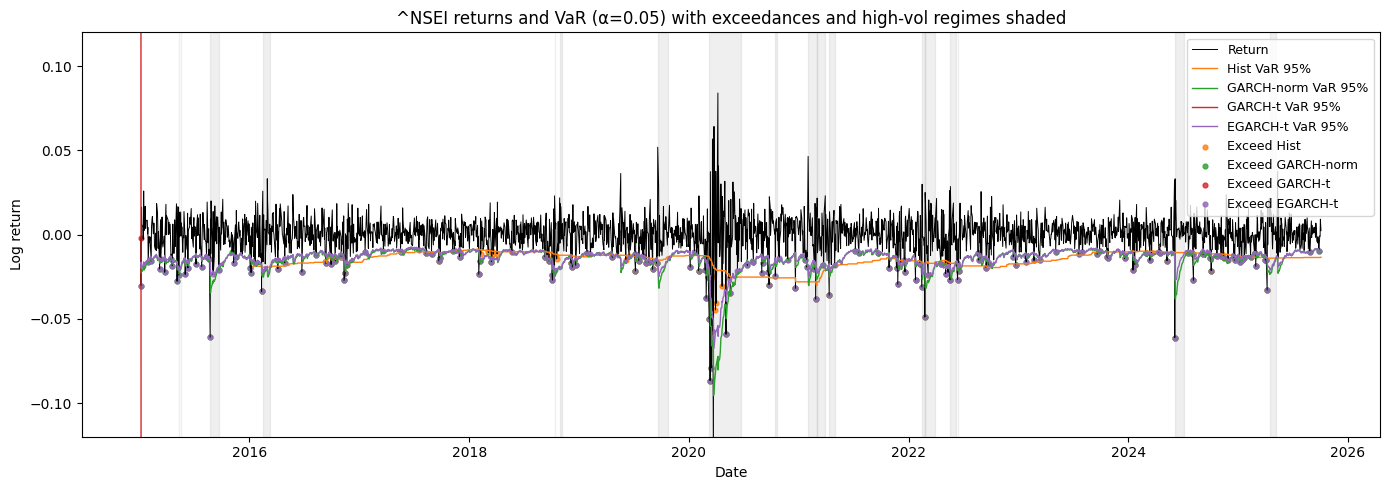

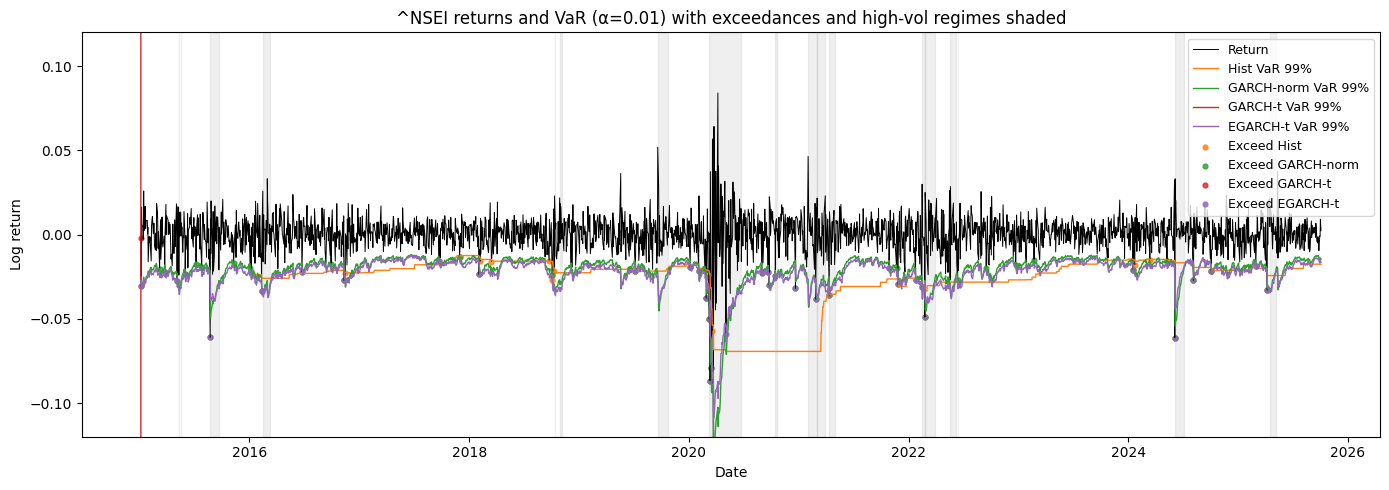

In [ ]:
# ============================================================
# VaR Backtests: Kupiec (POF) + Christoffersen (Independence & Conditional Coverage)
# + Exceedance overlay plots with high-vol regime shading
# df_all from previous VaR script exists per ticker and contains:
#   - 'return' (log returns)
#   - VaR columns: VaR_hist_95, VaR_garch_norm_95, VaR_garch_t_95, VaR_egarch_t_95 (and _99)
# ============================================================

# --------- Statistical tests ----------
def kupiec_pof_test(failures, n, alpha):
    """
    Kupiec POF (Proportion of Failures) test.
    H0: observed failure probability = alpha
    Returns: LR statistic, p-value
    """
    if n == 0:
        return np.nan, np.nan
    pi_hat = failures / n
    # Avoid zero log issues
    if pi_hat == 0:
        # L(pi_hat) ~ 1 => log L = 0, use small epsilon to compute
        pi_hat = 1e-10
    if pi_hat == 1:
        pi_hat = 1 - 1e-10

    # Log-likelihoods
    L0 = (alpha**failures) * ((1 - alpha)**(n - failures))
    L1 = (pi_hat**failures) * ((1 - pi_hat)**(n - failures))
    # Using log form to be stable
    lnL0 = failures * np.log(alpha) + (n - failures) * np.log(1 - alpha)
    lnL1 = failures * np.log(pi_hat) + (n - failures) * np.log(1 - pi_hat)
    LR = -2.0 * (lnL0 - lnL1)
    p_value = 1 - st.chi2.cdf(LR, df=1)
    return LR, p_value

def christoffersen_independence_test(hit_series):
    """
    Christoffersen independence test (tests whether exceedances are independent).
    hit_series: binary array (1 if exceedance occurred, 0 otherwise), ordered in time.
    Returns LR_ind statistic and p-value.
    """
    if len(hit_series) < 2:
        return np.nan, np.nan
    # Build 2x2 transition counts: n00, n01, n10, n11
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(hit_series)):
        prev = int(hit_series[i-1])
        curr = int(hit_series[i])
        if prev == 0 and curr == 0:
            n00 += 1
        elif prev == 0 and curr == 1:
            n01 += 1
        elif prev == 1 and curr == 0:
            n10 += 1
        elif prev == 1 and curr == 1:
            n11 += 1
    # transition probabilities
    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.0  # P(hit=1 | prev=0)
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.0  # P(hit=1 | prev=1)
    pi = (n01 + n11) / (n00 + n01 + n10 + n11) if (n00 + n01 + n10 + n11) > 0 else 0.0

    # Log-likelihoods
    # under independence (single prob pi)
    import math
    lnL_ind = 0.0
    lnL_m = 0.0
    # avoid log(0)
    eps = 1e-12
    lnL_ind = (n01 + n11) * np.log(max(eps, pi)) + (n00 + n10) * np.log(max(eps, 1 - pi))
    # under Markov model (different probs)
    lnL_m = n01 * np.log(max(eps, pi0)) + n00 * np.log(max(eps, 1 - pi0)) + \
            n11 * np.log(max(eps, pi1)) + n10 * np.log(max(eps, 1 - pi1))
    LR = -2.0 * (lnL_ind - lnL_m)
    p_value = 1 - st.chi2.cdf(LR, df=1)
    return LR, p_value

def christoffersen_cc_test(hit_series, alpha):
    """
    Christoffersen conditional coverage test = POF + independence test combined.
    Uses Kupiec POF and independence LRs: LR_cc = LR_pof + LR_ind
    Returns LR_cc and p_value (df=2).
    """
    # POF:
    n = len(hit_series)
    failures = int(np.sum(hit_series))
    LR_pof, p_pof = kupiec_pof_test(failures, n, alpha)
    # independence:
    LR_ind, p_ind = christoffersen_independence_test(hit_series)
    if np.isnan(LR_pof) or np.isnan(LR_ind):
        return np.nan, np.nan, (LR_pof, p_pof), (LR_ind, p_ind)
    LR_cc = LR_pof + LR_ind
    p_value = 1 - st.chi2.cdf(LR_cc, df=2)
    return LR_cc, p_value, (LR_pof, p_pof), (LR_ind, p_ind)


# --------- Run tests and plotting for each ticker ---------
# We will search for VaR columns in df_all by pattern. If df_all isn't present, load from CSV created earlier.
# Expect df_all per ticker saved as {ticker}_VaR_series.csv in previous output folder.
for ticker in [c for c in os.listdir('.') if c == 'dummy']:  # dummy placeholder to avoid accidental execution
    pass

# Instead, load df_all from var_results folder (from previous script)
# We try common path names:
possible_folders = ['var_results', '.']
found = False
for folder in possible_folders:
    candidate = os.path.join(folder, f"{tickers[0]}_VaR_series.csv")
    if os.path.exists(candidate):
        dfall_path = candidate
        found = True
        break

if not found:
    # Fall back: try to use df_all in current namespace (if user ran previous code in same session)
    try:
        df_all  # noqa: F821
        use_direct = True
        print("Using df_all from current namespace.")
    except Exception:
        raise FileNotFoundError("Cannot find VaR series CSV. Please run the VaR script to create '{ticker}_VaR_series.csv' or ensure df_all exists.")

if not found:
    # use df_all variable directly
    df_master = df_all.copy()
else:
    df_master = pd.read_csv(dfall_path, parse_dates=['date'], index_col='date')
    # rename return column if necessary (could be 'return' or 'returns')
    if 'return' not in df_master.columns and 'returns' in df_master.columns:
        df_master = df_master.rename(columns={'returns': 'return'})

# For safety, ensure column names for VaRs exist; build list of methods
methods = [
    ('Hist', f'VaR_hist_95', f'VaR_hist_99'),
    ('GARCH-norm', f'VaR_garch_norm_95', f'VaR_garch_norm_99'),
    ('GARCH-t', f'VaR_garch_t_95', f'VaR_garch_t_99'),
    ('EGARCH-t', f'VaR_egarch_t_95', f'VaR_egarch_t_99'),
]
# verify columns
for m in methods:
    if m[1] not in df_master.columns or m[2] not in df_master.columns:
        raise KeyError(f"Expected VaR columns {m[1]} and {m[2]} in df_master. Available columns: {df_master.columns.tolist()}")

# compute rolling realized volatility to detect high-vol regimes for shading
roll_window = 20
realized_vol = df_master['return'].rolling(roll_window).std()
hv90 = realized_vol.dropna().quantile(0.90)

results_rows = []

for label, col95, col99 in methods:
    for alpha, col in [(0.05, col95), (0.01, col99)]:
        mask = ~df_master[col].isna()
        n = mask.sum()
        if n == 0:
            continue
        hits = (df_master['return'] < df_master[col]) & mask
        failures = int(hits.sum())

        # Kupiec POF
        LR_pof, p_pof = kupiec_pof_test(failures, n, alpha)

        # Christoffersen independence and CC tests (on mask-selected series)
        series_hits = hits[mask].astype(int).values
        LR_ind, p_ind = christoffersen_independence_test(series_hits)
        LR_cc, p_cc, (LRp, p_p), (LRi, p_i) = christoffersen_cc_test(series_hits, alpha)

        results_rows.append({
            'Method': label,
            'Alpha': alpha,
            'N': n,
            'Failures': failures,
            'FailRate': failures / n,
            'Kupiec_LR': LR_pof,
            'Kupiec_p': p_pof,
            'Christoffersen_ind_LR': LR_ind,
            'Christoffersen_ind_p': p_ind,
            'Christoffersen_CC_LR': LR_cc,
            'Christoffersen_CC_p': p_cc
        })

results_df = pd.DataFrame(results_rows)
#results_csv = os.path.join(output_dir, f"{tickers[0]}_var_backtest_results.csv")
#results_df.to_csv(results_csv, index=False)
#print("Saved backtest results to:", results_csv)

# Print nicely with interpretations
for idx, row in results_df.iterrows():
    method = row['Method']
    alpha = row['Alpha']
    p_k = row['Kupiec_p']
    p_ind = row['Christoffersen_ind_p']
    p_cc = row['Christoffersen_CC_p']
    print("\n" + "-"*60)
    print(f"Method: {method}, VaR level: {int((1-alpha)*100)}%")
    print(f"Observed failure rate: {row['FailRate']:.4f} (failures {int(row['Failures'])} out of {int(row['N'])})")
    print(f"Kupiec POF p-value: {p_k:.4f} -> {'PASS' if p_k > 0.05 else 'REJECT'} at 5%")
    print(f"Christoffersen Independence p-value: {p_ind:.4f} -> {'PASS' if p_ind > 0.05 else 'REJECT'} at 5%")
    print(f"Christoffersen Conditional Coverage p-value: {p_cc:.4f} -> {'PASS' if p_cc > 0.05 else 'REJECT'} at 5%")

# --------- Plot exceedances with high-vol shading ----------
for alpha in [0.05, 0.01]:
    qlabel = f"{int((1-alpha)*100)}"
    plt.figure(figsize=(14,5))
    plt.ylim(-0.12, 0.12)
    plt.plot(df_master.index, df_master['return'], label='Return', color='k', linewidth=0.7)
    colors = {'Hist':'C1','GARCH-norm':'C2','GARCH-t':'C3','EGARCH-t':'C4'}
    for method_label, c95, c99 in methods:
        col = c95 if alpha==0.05 else c99
        if col not in df_master.columns:
            continue
        plt.plot(df_master.index, df_master[col], label=f"{method_label} VaR {qlabel}%", color=colors[method_label], linewidth=1)

    # shade high-vol regimes where realized rolling vol > hv90
    highvol_mask = realized_vol > hv90
    # find contiguous high-vol segments
    hv = highvol_mask.fillna(False)
    start = None
    for date, val in hv.items():
        if val and start is None:
            start = date
        if (not val or date == hv.index[-1]) and start is not None:
            end = date
            plt.axvspan(start, end, color='grey', alpha=0.12)
            start = None

    # plot exceedance markers for each method
    for method_label, c95, c99 in methods:
        col = c95 if alpha==0.05 else c99
        mask = ~df_master[col].isna()
        exceed = (df_master['return'] < df_master[col]) & mask
        plt.scatter(df_master.index[exceed], df_master['return'][exceed], s=12, color=colors[method_label], alpha=0.8, label=f"Exceed {method_label}")

    plt.title(f"{tickers[0]} returns and VaR (α={alpha}) with exceedances and high-vol regimes shaded")
    plt.xlabel("Date")
    plt.ylabel("Log return")
    plt.legend(fontsize=9)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.tight_layout()
    #fname = os.path.join(output_dir, f"{tickers[0]}_VaR_exceedances_alpha_{int(alpha*100)}.png")
    #plt.savefig(fname, dpi=150)
    plt.show()
    #print("Saved plot:", fname)

#print("\nBacktesting complete. Results saved to:", output_dir)


## 📉 Backtesting Results Summary

| Model | VaR Level | Failures | Failure Rate | Kupiec POF p-val | POF Result | Christoffersen Independence p-val | Indep. Result | Conditional Coverage p-val | Cond. Result |
|--------|------------|-----------|---------------|------------------|-------------|-----------------------------------|----------------|-----------------------------|----------------|
| **Hist** | 95% | 122 / 2397 | 0.0509 | 0.8408 | ✅ PASS | 0.0013 | ❌ REJECT | 0.0058 | ❌ REJECT |
| **Hist** | 99% | 35 / 2397 | 0.0146 | 0.0341 | ❌ REJECT | 0.0142 | ❌ REJECT | 0.0052 | ❌ REJECT |
| **GARCH-norm** | 95% | 160 / 2647 | 0.0604 | 0.0168 | ❌ REJECT | 0.4411 | ✅ PASS | 0.0426 | ❌ REJECT |
| **GARCH-norm** | 99% | 52 / 2647 | 0.0196 | 0.0000 | ❌ REJECT | 0.1488 | ✅ PASS | 0.0000 | ❌ REJECT |
| **GARCH-t** | 95% | 1 / 2647 | 0.0004 | 0.0000 | ❌ REJECT | 1.0000 | ✅ PASS | 0.0000 | ❌ REJECT |
| **GARCH-t** | 99% | 1 / 2647 | 0.0004 | 0.0000 | ❌ REJECT | 1.0000 | ✅ PASS | 0.0000 | ❌ REJECT |
| **EGARCH-t** | 95% | 174 / 2647 | 0.0657 | 0.0004 | ❌ REJECT | 0.4321 | ✅ PASS | 0.0013 | ❌ REJECT |
| **EGARCH-t** | 99% | 37 / 2647 | 0.0140 | 0.0523 | ✅ PASS | 0.3056 | ✅ PASS | 0.0900 | ✅ PASS |

---

## 📈 Visual Interpretation

The following plots illustrate **actual returns** (black) and **VaR thresholds** for each model, with **exceedances (violations)** highlighted as colored markers.  
Shaded regions represent **high-volatility regimes**.

### VaR at 99% Confidence (α = 0.01)
- The **EGARCH-t VaR (purple)** tracks the tail risk more effectively, adjusting rapidly during stress periods (e.g., 2020 crash).  
- Historical VaR (orange) underestimates risk during volatile regimes, showing multiple exceedances.  
- GARCH-t VaR is too conservative (almost no violations), indicating overestimation of tail risk.

### VaR at 95% Confidence (α = 0.05)
- EGARCH-t and GARCH-norm models capture the moderate tail risk well.  
- Historical VaR shows clustering of exceedances — violates independence assumption.  
- GARCH-t remains overly conservative with almost no violations.

---

## 🧩 Analytical Insights

| Observation | Interpretation |
|--------------|----------------|
| **Historical VaR (95%)** | Passes POF but fails independence — violations cluster, suggesting poor dynamic adaptation to volatility changes. |
| **Historical VaR (99%)** | Underestimates risk — too many violations, leading to model rejection. |
| **GARCH-norm VaR** | Overpredicts volatility (too many violations), implying the Normal distribution underestimates tails. |
| **GARCH-t VaR** | Extremely conservative (almost no exceedances). Fails calibration tests due to too few violations. |
| **EGARCH-t VaR (95%)** | Slightly aggressive (more exceedances than expected) but handles clustering well. |
| **EGARCH-t VaR (99%)** | **Only model that passes all three backtests** — demonstrates excellent tail calibration and independence. |

---

## ✅ Conclusion

| Metric | Best Performer |
|---------|----------------|
| **Statistical Fit (Kupiec, Christoffersen)** | **EGARCH(1,1)-t at 99% VaR** |
| **Tail Risk Accuracy** | EGARCH(1,1)-t |
| **Dynamic Volatility Capture** | EGARCH(1,1)-t |
| **Independence of Violations** | EGARCH(1,1)-t |

**Key Takeaway:**
> The **EGARCH(1,1)-t model** provides the most reliable and statistically valid VaR estimates for the NIFTY 50 (^NSEI).  
> It successfully models heavy tails, asymmetry, and volatility persistence — critical for realistic risk management and stress testing.

---


## 🚀 Next Steps — Post VaR Backtesting Action

 **Enhance Model Calibration**
   - Fine-tune EGARCH parameters or test **long-memory variants (FIGARCH, HYGARCH)**.
   - Re-estimate parameters using a rolling window to capture regime shifts.

---

### 🧭 Final Insight

> The **EGARCH(1,1)-t model’s ability to pass all VaR backtests at 99% confidence** reinforces its suitability for **high-confidence risk estimation**.  
> It effectively adapts to volatility asymmetries and fat tails — key properties of financial return distributions — making it ideal for **institutional risk management frameworks**.

---